In [1]:
%cd datasets/eurosat/data

/home/nam/datasets/eurosat/data


In [2]:
user_list = ["eurosat_ms", 'sentinel1/2_ms']
datasets_dict = dict.fromkeys(user_list)
list_datasets_size = []
print(datasets_dict)

{'eurosat_ms': None, 'sentinel1/2_ms': None}


In [3]:
from datasets import load_dataset

eurosat_dict = load_dataset("parquet", data_files={'train': 'train-*.parquet', 'test': 'test-*.parquet', 'validation': 'validation-*.parquet'})
print(f"eurosat_dict: {eurosat_dict}")
eurosat_list = list(eurosat_dict.values())
print(f"\n eurosat_list: {eurosat_list}")

/home/nam/.conda/envs/hf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


eurosat_dict: DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})

 eurosat_list: [Dataset({
    features: ['image', 'label', 'filename'],
    num_rows: 16200
}), Dataset({
    features: ['image', 'label', 'filename'],
    num_rows: 5400
}), Dataset({
    features: ['image', 'label', 'filename'],
    num_rows: 5400
})]


In [4]:
eurosat_trainset_dict = eurosat_list[0]
print(eurosat_trainset_dict)
print(len(eurosat_trainset_dict))
datasets_dict['eurosat_ms'] = eurosat_trainset_dict
list_datasets_size.append(len(eurosat_trainset_dict))

Dataset({
    features: ['image', 'label', 'filename'],
    num_rows: 16200
})
16200


In [5]:
batch_eurosat_trainset_dict = eurosat_trainset_dict.select(range(100, 100 + 16))
print(batch_eurosat_trainset_dict)
print(len(batch_eurosat_trainset_dict))

Dataset({
    features: ['image', 'label', 'filename'],
    num_rows: 16
})
16


Shape of batch: (16, 64, 64, 13)
Shape of 1 multispectral sample: (64, 64, 13)
Shape of 1 rgb sample: (64, 64, 3)


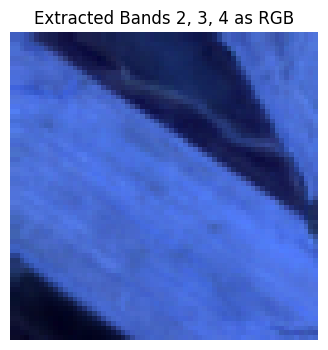

In [7]:
# batch_rgb = list(batch_eurosat_trainset_dict[key] for key in ['image', 'images', 'rgb', 'rgbs'] if key in eurosat_trainset_dict)
import numpy as np
import matplotlib.pyplot as plt

for key in ['image', 'images', 'rgb', 'rgbs']:
    if key in batch_eurosat_trainset_dict.column_names:
        batch_rgb = batch_eurosat_trainset_dict[key]
        
np_batch_rgb = np.array(batch_rgb)
print("Shape of batch:", np_batch_rgb.shape)

ms_sample = np_batch_rgb[0]
print("Shape of 1 multispectral sample:", ms_sample.shape)

rgb_sample = ms_sample[:, :, 1:4]
print("Shape of 1 rgb sample:", rgb_sample.shape)


if rgb_sample.dtype != np.uint8:
    bands_min = rgb_sample.min()
    bands_max = rgb_sample.max()
    bands_norm = (rgb_sample - bands_min) / (bands_max - bands_min)
    bands_uint8 = (bands_norm * 255).astype(np.uint8)
else:
    bands_uint8 = rgb_sample

plt.figure(figsize=(4, 4))
plt.imshow(bands_uint8)
plt.axis('off')  # Turn off the axis
plt.title("Extracted Bands 2, 3, 4 as RGB")
plt.show()

(32, 32, 3)


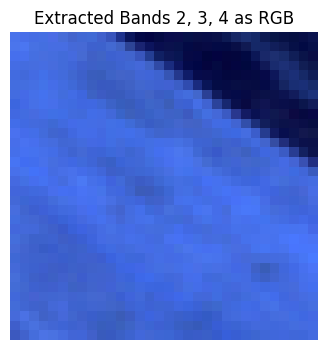

In [8]:
import matplotlib.pyplot as plt

def crop_center(img,cropx,cropy):
    y,x = img.shape[1:3]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[:, starty:starty+cropy,startx:startx+cropx, ...]

np_batch_rgb = crop_center(np_batch_rgb, 32, 32)
ms_sample = np_batch_rgb[0]
rgb_sample = ms_sample[:, :, 1:4]
print(rgb_sample.shape)

if rgb_sample.dtype != np.uint8:
    bands_min = rgb_sample.min()
    bands_max = rgb_sample.max()
    bands_norm = (rgb_sample - bands_min) / (bands_max - bands_min)
    bands_uint8 = (bands_norm * 255).astype(np.uint8)
else:
    bands_uint8 = rgb_sample

plt.figure(figsize=(4, 4))
plt.imshow(bands_uint8)
plt.axis('off')  # Turn off the axis
plt.title("Extracted Bands 2, 3, 4 as RGB")
plt.show()

In [9]:
import os
import glob
from PIL import Image
from pathlib import Path

root_dir = '/home/nam/ROIs2017_winter_lc'
ROI2017_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)
ROI2017_paths = [Path(p) for p in ROI2017_paths]
print(len(ROI2017_paths))
datasets_dict['sentinel1/2_ms'] = ROI2017_paths
list_datasets_size.append(len(ROI2017_paths))

31825


In [10]:
merged_dataset_size = min(list_datasets_size)
print(merged_dataset_size)

16200


In [14]:
# images = test_set['image']  # dont do this, you are practically loading 5400 samples into memory
import datasets 
import numpy as np
from osgeo import gdal

combined_batch_size = 32
num_datasets = 2
per_dataset_batch_size = int(combined_batch_size/num_datasets)


combined_batch_np = np.array([[0]])
arbiter_dataset_size = 200
merged_H = 64
merged_W = 64
for i in range(0, arbiter_dataset_size, combined_batch_size):
    for _, dataset in datasets_dict.items():
        if isinstance(dataset, list):
            skipped_i_list = 0
            metadata_batch = dataset[(skipped_i_list + i):(skipped_i_list + i + per_dataset_batch_size)]
            if isinstance(metadata_batch[0], Path):
                # not sure if it works with .geotiff, should do
                batch_np = np.array([[0]])
                if metadata_batch[0].suffix.lower() in ['.tif', '.tiff', '.geotiff']:
                    for path in metadata_batch:
                        sample = gdal.Open(str(path)) 
                        band_arrays = []
                        # assume rgb bands = 2,3,4
                        for band in [2,3,4]:
                            raster_band = sample.GetRasterBand(band)
                            band_arrays.append(raster_band.ReadAsArray())
                
                        sample_np = np.stack(band_arrays, axis=-1)
                        if sample_np.dtype != np.uint8:
                            sample_np_temp = sample_np
                            # return shape shape (B, 1, 1, C) that contains min, max for each channel in each sample
                            min_vals = sample_np_temp.min(axis=(1, 2), keepdims=True)
                            max_vals = sample_np_temp.max(axis=(1, 2), keepdims=True)
                            
                            ranges = max_vals - min_vals
                            ranges[ranges == 0] = 1
                            sample_np_temp = (sample_np_temp - min_vals) / ranges * 255
                            sample_np = sample_np_temp.astype(np.uint8) 
                        sample_np = np.expand_dims(sample_np, axis=0)
                        
                        if batch_np.ndim == sample_np.ndim:
                            batch_np = np.concatenate((batch_np, sample_np), axis=0)
                        else:
                            batch_np = sample_np
                    
                    print(f"sentinel1/2 shape before processing is {batch_np.shape}")
                    H,W = batch_np.shape[1:3]
                    if H < merged_H or W < merged_W:
                        skipped_i_list += per_dataset_batch_size
                        metadata_batch = dataset.select(range(skipped_i_list, skipped_i_list + per_dataset_batch_size))
                    elif H > merged_H or W > merged_W:
                        batch_np = crop_center(batch_np, merged_H, merged_W)
                
                    print(f"sentinel1/2 shape after processing is {batch_np.shape}")
                            
                            
        elif isinstance(dataset, datasets.arrow_dataset.Dataset):
            skipped_i_dataset = 0
            metadata_batch = dataset.select(range(skipped_i_dataset + i, skipped_i_dataset + i + per_dataset_batch_size))
            batch_np = np.array([[0]])
            if (key := next(iter(set(metadata_batch.column_names) & {'rgb', 'rgbs'}), None)) is not None:
                batch_image = metadata_batch[key]
                # same thing as 
                '''
                for key in ['rgb', 'rgbs']:
                    if key in metadata_batch.column_names:
                        batch_image = metadata_batch[key]

                '''
                batch_np = np.array(batch_image)
                # take into account for bi-temporal images for Change Detection
                if batch_np.ndim == 5:
                    continue
                H,W = batch_np.shape[1:3]
                if H < merged_H or W < merged_W:
                    skipped_i_dataset += per_dataset_batch_size
                    metadata_batch = dataset.select(range(skipped_i_dataset, skipped_i_dataset + per_dataset_batch_size))
                    batch_np = np.array(metadata_batch[key])
                elif H > merged_H or W > merged_W:
                    batch_np = crop_center(batch_np, merged_H, merged_W)
                print(f"eurosat shape is {batch_np.shape}")

                if batch_np.dtype != np.uint8:
                    batch_np_temp = batch_np
                    # return shape shape (B, 1, 1, C) that contains min, max for each channel in each sample
                    min_vals = batch_np_temp.min(axis=(1, 2), keepdims=True)
                    max_vals = batch_np_temp.max(axis=(1, 2), keepdims=True)
                    
                    ranges = max_vals - min_vals
                    ranges[ranges == 0] = 1
                    batch_np_temp = (batch_np_temp - min_vals) / ranges * 255
                    batch_np = batch_np_temp.astype(np.uint8) 
                    
            elif (key := next(iter(set(metadata_batch.column_names) & {'ms'}), None)) is not None:
                batch_image = metadata_batch[key]
                batch_np = np.array(batch_image)
                print(f"eurosat shape before processing is {batch_np.shape}")
                # take into account for bi-temporal images for Change Detection
                if batch_np.ndim == 5:
                    continue
                else:
                    H,W = batch_np.shape[1:3]
                    if H < merged_H or W < merged_W:
                        skipped_i_dataset += per_dataset_batch_size
                        metadata_batch = dataset.select(range(skipped_i_dataset, skipped_i_dataset + per_dataset_batch_size))
                        batch_np = np.array(metadata_batch[key])
                    elif H > merged_H or W > merged_W:
                        batch_np = crop_center(batch_np, merged_H, merged_W)
                
                # by default extract band 2,3,4 but will need to add if-condition to check dataset name i.e. <if dataset is 'eurosat'>
                batch_np = batch_np[:, :, :, 1:4]
                if batch_np.dtype != np.uint8:
                    batch_np_temp = batch_np
                    # return shape shape (B, 1, 1, C) that contains min, max for each channel in each sample
                    min_vals = batch_np_temp.min(axis=(1, 2), keepdims=True)
                    max_vals = batch_np_temp.max(axis=(1, 2), keepdims=True)
                    
                    ranges = max_vals - min_vals
                    ranges[ranges == 0] = 1
                    batch_np_temp = (batch_np_temp - min_vals) / ranges * 255
                    batch_np = batch_np_temp.astype(np.uint8) 
               
            elif (key := next(iter(set(metadata_batch.column_names) & {'image', 'images'}), None)) is not None:
                batch_image = metadata_batch[key]
                batch_np = np.array(batch_image)
                print(f"eurosat shape before processing is {batch_np.shape}")
                # take into account for bi-temporal images for Change Detection
                if batch_np.ndim == 5:
                    continue  
                else:     
                    H,W = batch_np.shape[1:3]
                    if H < merged_H or W < merged_W:
                        skipped_i_dataset += per_dataset_batch_size
                        metadata_batch = dataset.select(range(skipped_i_dataset, skipped_i_dataset + per_dataset_batch_size))
                        batch_np = np.array(metadata_batch[key])
                    elif H > merged_H or W > merged_W:
                        batch_np = crop_center(batch_np, merged_H, merged_W)
                
                # multispectral images
                if batch_np.shape[-1] > 3:
                    # by default extract band 2,3,4 but will need to add if-condition to check dataset name
                    # if dataset is 'eurosat'
                    batch_np = batch_np[:, :, :, 1:4]
 
                elif batch_np.shape[-1] < 3:
                    print("Need to look into each sample of this remote sensing dataset")
                    continue

                
                if batch_np.dtype != np.uint8:
                    batch_np_temp = batch_np
                    # return shape shape (B, 1, 1, C) that contains min, max for each channel in each sample
                    min_vals = batch_np_temp.min(axis=(1, 2), keepdims=True)
                    max_vals = batch_np_temp.max(axis=(1, 2), keepdims=True)
                    
                    ranges = max_vals - min_vals
                    ranges[ranges == 0] = 1
                    batch_np_temp = (batch_np_temp - min_vals) / ranges * 255
                    batch_np = batch_np_temp.astype(np.uint8)   
                    
                print(f"eurosat shape after processing is {batch_np.shape}")

        if combined_batch_np.ndim == batch_np.ndim:
            combined_batch_np = np.concatenate((combined_batch_np, batch_np), axis=0)
        else:
            combined_batch_np = batch_np
                   
print(combined_batch_np.shape)


eurosat shape before processing is (16, 64, 64, 13)
eurosat shape after processing is (16, 64, 64, 3)
sentinel1/2 shape before processing is (16, 256, 256, 3)
sentinel1/2 shape after processing is (16, 64, 64, 3)
eurosat shape before processing is (16, 64, 64, 13)
eurosat shape after processing is (16, 64, 64, 3)
sentinel1/2 shape before processing is (16, 256, 256, 3)
sentinel1/2 shape after processing is (16, 64, 64, 3)
eurosat shape before processing is (16, 64, 64, 13)
eurosat shape after processing is (16, 64, 64, 3)
sentinel1/2 shape before processing is (16, 256, 256, 3)
sentinel1/2 shape after processing is (16, 64, 64, 3)
eurosat shape before processing is (16, 64, 64, 13)
eurosat shape after processing is (16, 64, 64, 3)
sentinel1/2 shape before processing is (16, 256, 256, 3)
sentinel1/2 shape after processing is (16, 64, 64, 3)
eurosat shape before processing is (16, 64, 64, 13)
eurosat shape after processing is (16, 64, 64, 3)
sentinel1/2 shape before processing is (16, 25